## FFT 1D

 author : Sylvie Dagoret-Campagne
- aflilation IJCLab/IN2P3/CNRS
- creation date 2025-01-11
- doc on FFT : https://numpy.org/doc/2.0/reference/generated/numpy.fft.fft.html
- conda environnement : poppy_conda_py312 (on my macbook)
- install poppy : https://poppy-optics.readthedocs.io/en/latest/
- install rise in jupyterlab to see the slides : https://github.com/jupyterlab-contrib/rise
- install pandoc for documentation

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

### Auxtel Configuration

In [2]:
# wavelength in m
wl = 0.5e-6
# pixel scale
# 10 microns pixel , 105 microns per arcsec
pix_scale = 10.0/105.0 # arcsec per pixel
fov_arcsec = 5.0 # must restrict the FOV in focl plane to avoid aliasing
# diameter in m
D = 1.2
Fnum = 18
# focal length
FL = D*Fnum
# Dccd
Dccd = 180e-3
# beam radius at object positon
beam_radius_m =  D/2/FL*Dccd
beam_radius_mm =  D/2/FL*Dccd*1000

In [3]:
beam_radius_mm

5.0

### Diffraction Pattern

In [4]:
Neff = 150
xmin = -0.05
xmax = 0.05
dxt = xmax-xmin

In [5]:
def set_ronchi_transmission_debug(x,opticalelement_nblines_permm=Neff):
    """
    Generate a square pattern of transmission.
    x in mm
    """
    a = 1/opticalelement_nblines_permm
    return np.rint(x/a-0.25 - np.floor(x/a-0.25))

Text(0.5, 0, 'mm')

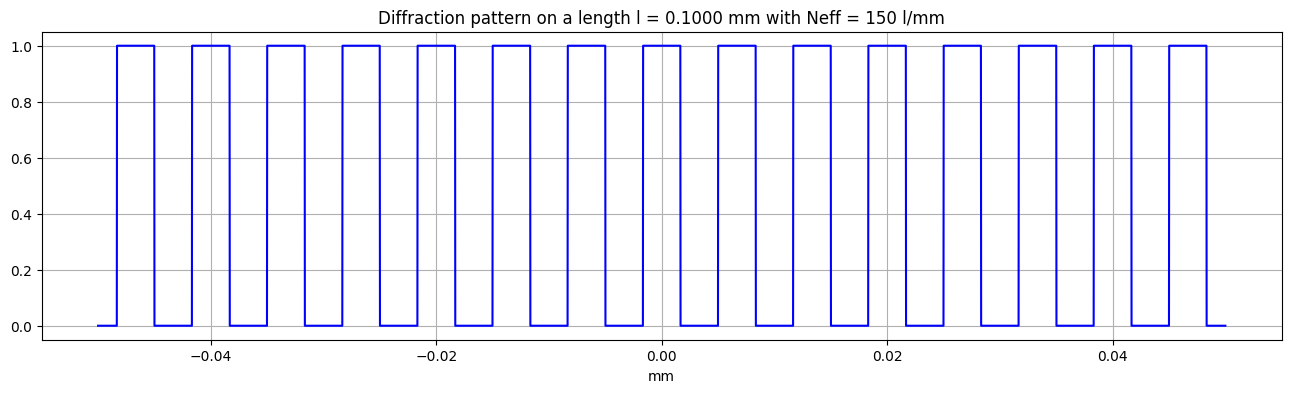

In [6]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
x = np.linspace(-0.05,0.05,5000)
y = set_ronchi_transmission_debug(x)
ax.plot(x,y,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on a length l = {dxt:.4f} mm with Neff = {Neff} l/mm")
ax.set_xlabel("mm")

### Parameters of the FFT

In [7]:
Nb = 10001
padding_factor = 1.5

In [8]:
# x in units of mm
xe = np.linspace(-beam_radius_mm*padding_factor,+beam_radius_mm*padding_factor,Nb)
dxe = np.diff(xe).mean()

In [9]:
ye = set_ronchi_transmission_debug(xe)

In [10]:
a = np.where(np.logical_or(xe<-beam_radius_mm,xe>beam_radius_mm),0,ye)

Text(0.5, 0, 'mm')

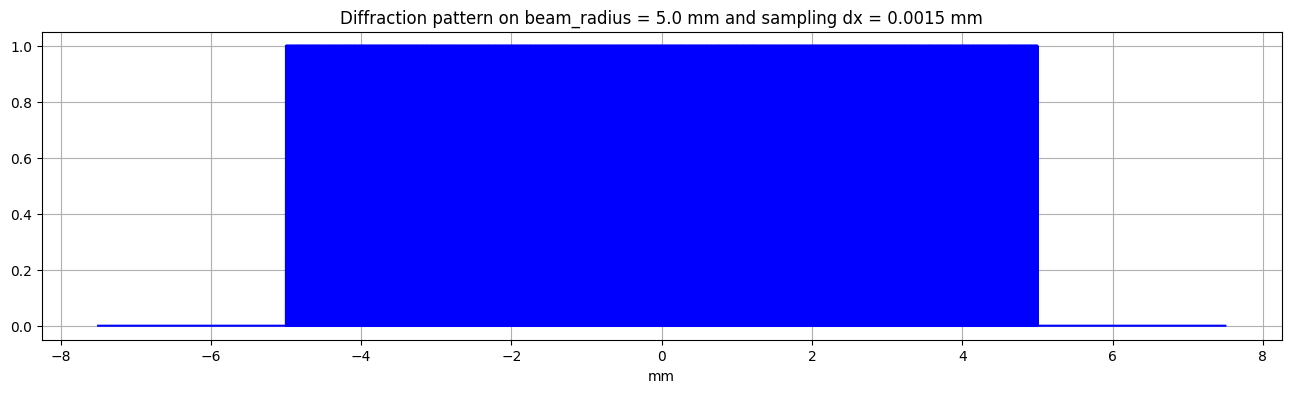

In [11]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(xe,a,'b-')
ax.grid()
ax.set_title(f"Diffraction pattern on beam_radius = {beam_radius_mm} mm and sampling dx = {dxe:.4f} mm")
ax.set_xlabel("mm")

In [12]:
sp = np.fft.fft(a)
# the frequency in units of mm^-1
freq = np.fft.fftfreq(a.shape[-1], d=dxe)

module = np.abs(sp)
phase = np.angle(sp)

In [13]:
Neff

150

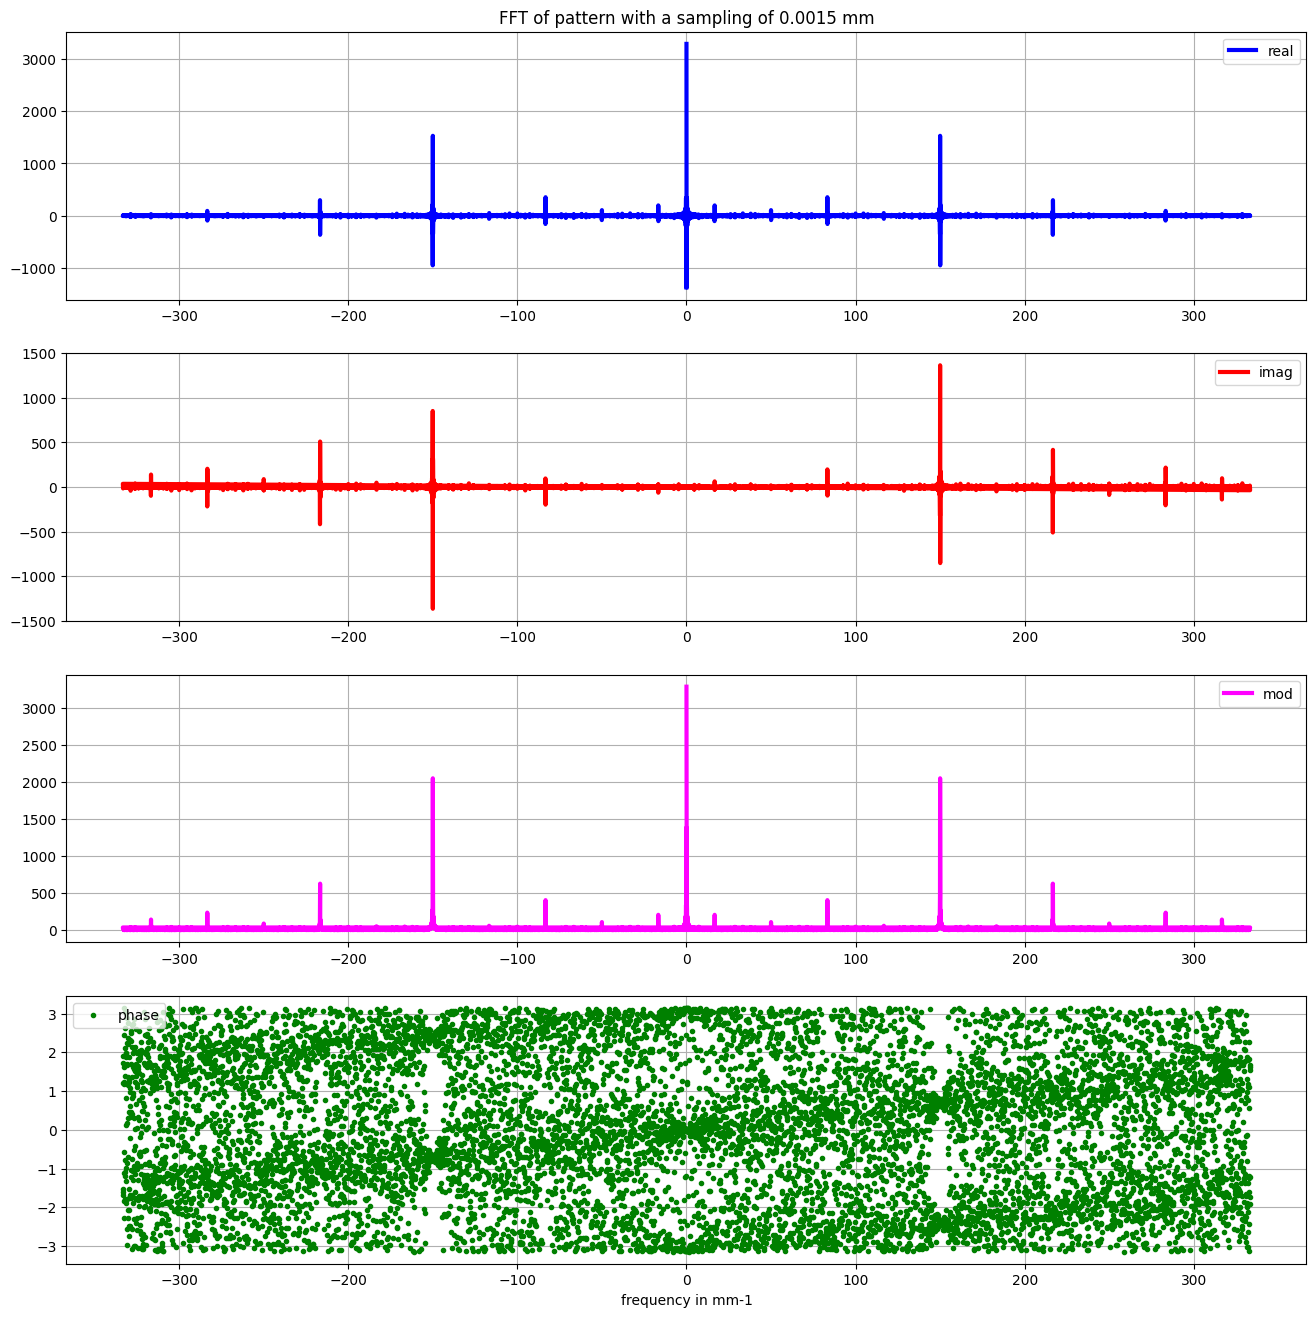

In [18]:
fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(16,16))
ax1.plot(freq, sp.real, 'b',lw=3, label = "real")
ax1.grid()
ax1.set_title(f"FFT of pattern with a sampling of {dxe:.4f} mm")
ax2.plot(freq, sp.imag, 'r',lw=3, label = "imag")
ax2.grid()
ax3.plot(freq, module, c='magenta',lw=3, label = "mod")
ax3.grid()
ax4.plot(freq, phase,'.g',lw=3, label = "phase")
ax4.grid()
ax4.set_xlabel("frequency in mm-1")
ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

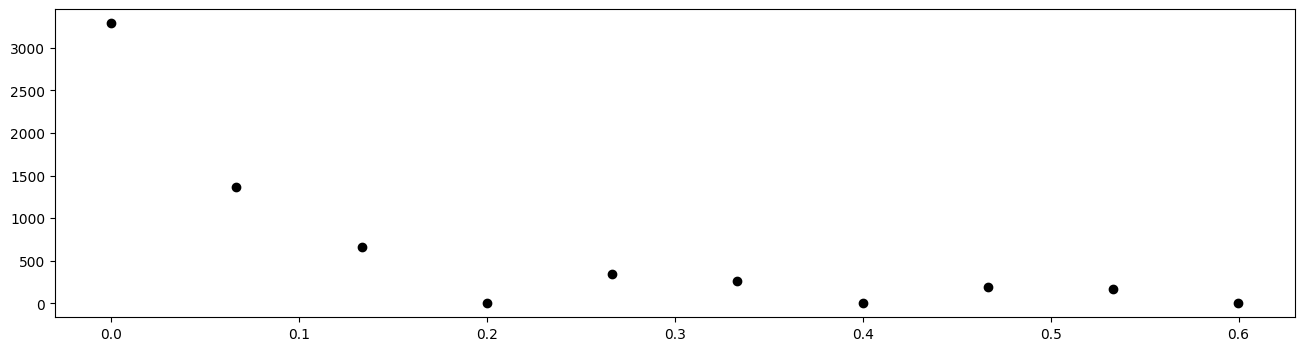

In [17]:
fig,ax = plt.subplots(1,1,figsize=(16,4))
ax.plot(freq[0:10],module[0:10],'ok')

In [ ]:
sp.real[0:10]

In [ ]:
sp.imag[0:10]

In [ ]:
mod[0:10]